In [73]:
"""
Created on Wed Aug 4 17:50:06 2021
@author: Dwyer
"""

# set TF GPU memory growth so that it doesn't hog everything at once
import tensorflow as tf
tf.keras.backend.set_floatx('float64')
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import os
import numpy as np
from optuna_train import *
debug_mode = True  # faster experiments for debugging

def print_scientific_notation(number):
    power = int(np.log(number)/np.log(10))
    print(f"Scientific Notation: {(loss/10**power)}*10^{power}")
    
import pandas as pd
assert pd.__path__[0]!='/opt/anaconda/lib/python3.8/site-packages/pandas', 'Error! You are using deprecated pandas package outside your conda environment. Did you use Jupyter Lab again?' 
# this is a nefarious problem with current version of anaconda, root cause is conda version install your own local one!
# lightly more superficial root cause is that you sometimes use jupyter lab which triggers you to use the /opt/anaconda/bin path backup when it sees jupyter lab isn't in local environment which breaks everything (uses outdated pandas)

In [74]:
#Prepare the DataFrame that will be used downstream
dp = DataPreparer(fn='../datasets/methane_air_master.csv')
df = dp.getDataframe()

# currently passing dp eventually we want to abstract all the constants into 1 class
dm = DataManager(df, dp)

In [75]:
""" prepare PCDNNV2 for loading (from prior experiments) """

exprExec = PCDNNV2ExperimentExecutor()
exprExec.debug_mode = debug_mode
exprExec.setModelFactory(PCDNNV2ModelFactory())

Parent DNNModelFactory Instantiated
Parent DNNModelFactory Instantiated


Model: "regressor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 13)]         0           []                               
                                                                                                  
 regressor (Functional)         {'static_source_pre  18525693    ['input_1[0][0]']                
                                diction': (None, 54                                               
                                ),                                                                
                                 'dynamic_source_pr                                               
                                ediction': (None, 1                                               
                                2)}                                                       

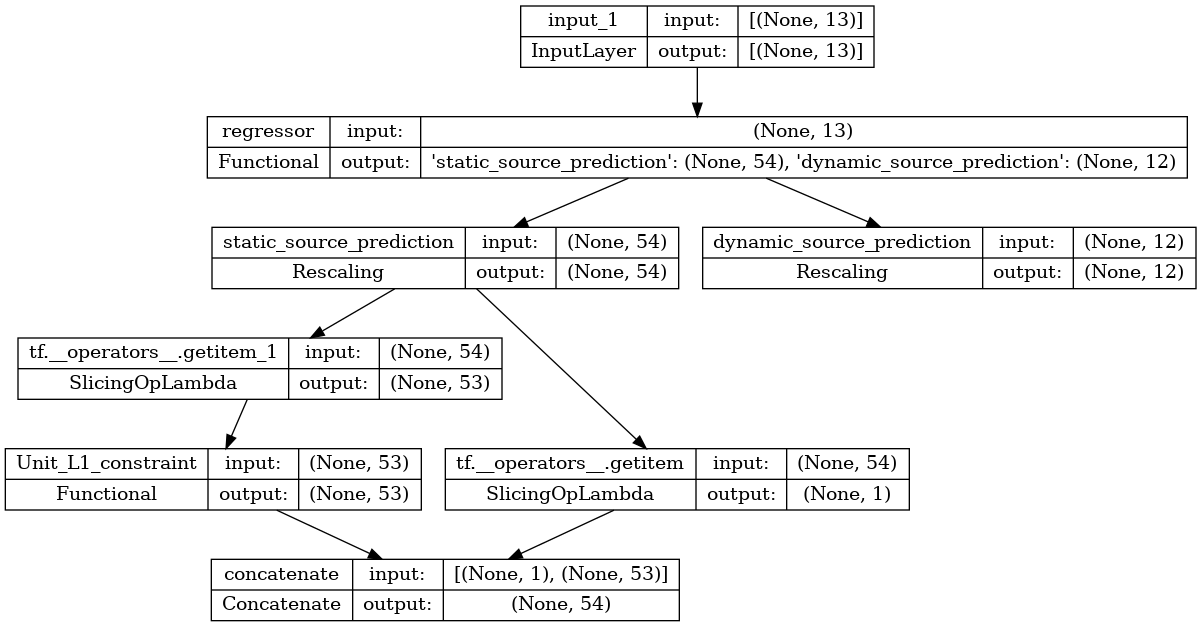

In [122]:
import tensorflow as tf
from tensorflow import keras
regressor = keras.models.load_model('./PCDNNV2_decomp/regressor')
regressor.summary()
tf.keras.utils.plot_model(regressor, show_shapes=True)

Model: "linear_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 species_input (InputLayer)  [(None, 53)]              0         
                                                                 
 linear_embedding (Dense)    (None, 12)                636       
                                                                 
Total params: 636
Trainable params: 636
Non-trainable params: 0
_________________________________________________________________


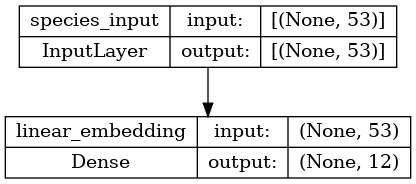

In [121]:
linear_encoder = keras.models.load_model('./PCDNNV2_decomp/linear_embedding')
linear_encoder.summary()
tf.keras.utils.plot_model(linear_encoder, show_shapes=True)

In [82]:
import pandas as pd
df = pd.read_csv('../datasets/wax_master.csv')

Yi_cols = filter(lambda x: x.startswith('Yi'), df.columns)
Yi_df = df[Yi_cols]
assert np.all(Yi_df>=0)
df.head()
Yi_df.head()

,YiCH4,YiH,YiO,YiO2,YiOH,YiH2O,YiHO2,YiH2O2,YiC,YiCH,...,YiHCNO,YiHOCN,YiHNCO,YiNCO,YiC3H7,YiC3H8,YiCH2CHO,YiCH3CHO,YiN2,YiAR
0,0.000000e+00,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1.289260e-12,5.460416e-07,0.000138,0.976623,0.000202,0.006797,0.000013,0.000006,3.186506e-17,1.350704e-17,...,1.257617e-15,4.701047e-14,1.144945e-10,2.484232e-11,1.393788e-21,1.290335e-19,5.786306e-17,3.131394e-17,6.454338e-09,2.597922e-14
2,2.170419e-12,1.383290e-06,0.000345,0.949808,0.000502,0.014538,0.000023,0.000008,8.079636e-17,3.424817e-17,...,2.372987e-15,9.744924e-14,2.137514e-10,6.210792e-11,2.841729e-21,2.836953e-19,1.256954e-16,5.234732e-17,1.345556e-08,5.584422e-14
3,2.240723e-12,2.366054e-06,0.000586,0.927690,0.000845,0.020841,0.000027,0.000007,1.385346e-16,5.872238e-17,...,3.004982e-15,1.348136e-13,2.491755e-10,4.417845e-11,3.570318e-21,4.413814e-19,1.652283e-16,5.362204e-17,1.861340e-08,7.993606e-14
4,1.793555e-12,3.593707e-06,0.000878,0.907820,0.001268,0.026405,0.000027,0.000006,2.116633e-16,8.972037e-17,...,3.228248e-15,1.639363e-13,2.441298e-10,3.444847e-11,4.642443e-21,6.422780e-19,2.262596e-16,4.059161e-17,2.306593e-08,1.020295e-13


In [123]:
linear_embeddings = linear_encoder(np.asarray(Yi_df))
regressor_inputs = np.concatenate((np.asarray(df['Zmix']).reshape(-1,1), linear_embeddings.numpy()), axis=1)
# add Zmix on the left

In [134]:
regressor_outs = regressor(regressor_inputs)
inversion_outputs=regressor_outs['static_source_prediction'].numpy()[:,:]

def R2(yt,yp): return tf.reduce_mean(1-tf.reduce_mean((yp-yt)**2, axis=0)/tf.math.reduce_variance(yt,axis=0))

targets = np.concatenate((np.asarray(df['souener']).reshape(-1,1), np.asarray(Yi_df)),axis=1)
print('R2 raw: ', R2(targets, inversion_outputs))

R2 raw:  tf.Tensor(0.8381003930048109, shape=(), dtype=float64)


In [125]:
from sklearn.preprocessing import StandardScaler
Yi_scaler = StandardScaler()
Yi_df_scaled = Yi_scaler.fit_transform(Yi_df)

#mb = np.loadtxt('PCDNNV2_decomp/scaling_params.txt')
#m, b = mb[0:1,1:], mb[1:2,1:] # row range --> preserves shape, 1: in columns --> skips souener rescaling
#print(m)
#print(b)

def rescaling_and_constraint(inversion_outputs):
    inversion_outputs = inversion_outputs*m+b
    display(inversion_outputs)
    inversion_outputs = np.maximum(inversion_outputs, 0)
    inversion_outputs = np.minimum(inversion_outputs, 1)
    display(inversion_outputs)
    inversion_outputs /= np.sum(inversion_outputs, axis=1, keepdims=True)
    return inversion_outputs


#print('R2 in scaled domain: ', R2(np.asarray(Yi_df_scaled), inversion_outputs))
#print('R2 in original domain: ', R2(np.asarray(Yi_df), Yi_scaler.inverse_transform(inversion_outputs)))
#print('R2 in original domain (w/ constraint): ', R2(np.asarray(Yi_df), rescaling_and_constraint(inversion_outputs)))

[[1.05280310e-02 1.50374476e-03 1.71921228e-02 2.82176613e-01
  2.49179531e-02 7.20424975e-02 2.30191048e-04 1.07940582e-04
  8.00438447e-05 6.17455876e-05 1.88334029e-04 4.29601039e-05
  1.52795012e-03 1.64342559e-02 2.37953025e-01 8.55314027e-02
  1.63390105e-04 7.49754677e-04 2.67915915e-05 2.17865276e-05
  5.22116000e-05 2.56617004e-04 5.94101602e-02 1.52293131e-03
  2.62544708e-01 1.16634368e-04 3.81131956e-03 6.64424741e-04
  3.17549619e-03 1.17355210e-04 8.63319765e-11 5.53554031e-11
  8.12967879e-11 1.70151993e-09 6.31679940e-15 5.17248537e-08
  1.08867169e-10 1.65816742e-13 7.58568081e-12 2.63534816e-11
  1.75248213e-08 5.72053554e-13 2.22988115e-16 1.53529617e-11
  3.70207676e-12 2.74688233e-10 1.80617441e-10 5.38568670e-05
  7.80377164e-03 1.66320226e-04 3.62017693e-05 3.52335151e-08
  2.83647391e-13]]
[[9.88050139e-03 1.08349625e-03 1.07799997e-02 2.05397018e-01
  1.70808303e-02 1.00138934e-01 1.18628476e-04 4.14573692e-05
  2.47166993e-05 1.88608527e-05 6.89894799e-05 1.27

In [91]:
pd.DataFrame(Yi_scaler.inverse_transform(inversion_outputs)[:5,:5], columns=Yi_df.columns[:5])

,YiCH4,YiH,YiO,YiO2,YiOH
0,0.000450,0.000094,0.000782,0.943083,-0.001459
1,0.000354,0.000078,0.001378,0.938324,-0.001016
2,0.000250,0.000056,0.002274,0.927282,-0.000254
3,0.000243,0.000037,0.003140,0.911514,0.000584
4,0.000312,0.000013,0.003991,0.893684,0.001468


In [128]:
Yi_df.iloc[:5,:5]

,YiCH4,YiH,YiO,YiO2,YiOH
0,0.000000e+00,0.000000e+00,0.000000,1.000000,0.000000
1,1.289260e-12,5.460416e-07,0.000138,0.976623,0.000202
2,2.170419e-12,1.383290e-06,0.000345,0.949808,0.000502
3,2.240723e-12,2.366054e-06,0.000586,0.927690,0.000845
4,1.793555e-12,3.593707e-06,0.000878,0.907820,0.001268


In [131]:
pd.DataFrame(inversion_outputs[:5,:5], columns=Yi_df.columns[:5])

,YiCH4,YiH,YiO,YiO2,YiOH
0,0.000457,0.000095,0.000794,0.957808,0.000000
1,0.000359,0.000079,0.001397,0.950921,0.000000
2,0.000253,0.000056,0.002300,0.937839,0.000000
3,0.000246,0.000037,0.003174,0.921128,0.000590
4,0.000315,0.000013,0.004028,0.902074,0.001482


In [136]:
df['Zmix'].describe()

count    18662.000000
mean         0.443664
std          0.259339
min          0.000000
25%          0.227864
50%          0.419251
75%          0.650699
max          0.974697
Name: Zmix, dtype: float64